In [ ]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import sklearn.linear_model as linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt
import pandas as pd

# 1 Polynomial Regression visited again

In this exercise we will have a look again at overfitting and underfitting using the example of a polynomial regression.


In [ ]:
# This function generates data from a polynome, possibly with noise
def generate_polynome_data(polynome, noise_std, n,bound=2):
    """
    arguments:
        - polynome  : list of coefficients representing the polynom (polynome[i] multiplies X^i)
        - noise_std : standard deviation of the gaussian noise
        - n         : number of data points
        - bound     : for points x the sampling inverval is +-bound
    returns:
        - (X, y)    : list of n points with y = poly(x) + gaussian noise
    """
    rs = np.random.RandomState(51)
    degree  = len(polynome) - 1
    samples = rs.uniform(-bound, bound, size=n)
    xs      = np.copy(samples)
    samples = np.ones((n, degree + 1)).T * samples
    powers  = np.power(samples.T, np.arange(0, degree + 1, 1))
    return xs.reshape(-1, 1), np.sum(powers * polynome, axis = 1) + rs.normal(0, noise_std, size=n)

## 1.1 Noiseless data

Generate _noiseless_ points $x_1, ... x_n$ with few samples (say $5 \leqslant n \leqslant 10$) from the polynomial $y_i = x_i^2  + 0.5 x_i^3$.

Plot the resulting data.

In [ ]:
# Create 6 noiseless datapoints within the training interval [+2,-2]
X_train, y_train = ... # TODO

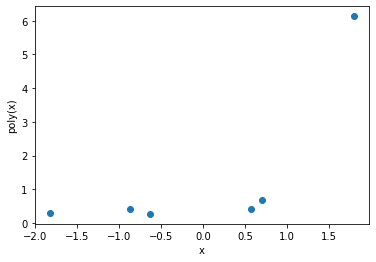

In [ ]:
# Show the training data in a scatter plot
... # TODO
plt.xlabel('x')
plt.ylabel('poly(x)');

We want to create some data for testing too, say 25 datapoints.

In [ ]:
# Create some test data
test_bound  = 2
n = 25
X_test, y_test = ... # TODO

## 1.2 Polynomials of different degrees as estimator
Run Linear regression with no regulariser, but generate polynomial features of degree d from the input data $x_i$ using [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) from sklearn. This way you can obtain a Polynomial Regression.

Then use the model as a predictor for the plot, train and test inputs X.

In [ ]:
# Create some data to plot the estimator
plot_bound  = 3.5
X_plot = np.linspace(-plot_bound, plot_bound, 50).reshape((-1,1))

Degree 1 : training error is 3.6241212940895444, test error is 6.306753479032214
Degree 3 : training error is 1.3391885469243657e-15, test error is 2.389641287401268e-15
Degree 5 : training error is 6.771452645544412e-14, test error is 6.5353526433787e-13
Degree 7 : training error is 1.3274711585551136e-14, test error is 0.20714500314189563
Degree 9 : training error is 8.647098019618493e-15, test error is 0.4625312404506581


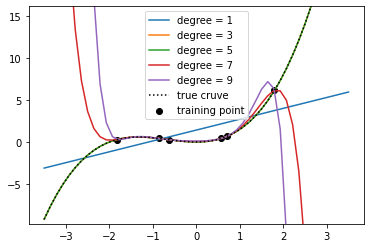

In [ ]:
# fit a model for every odd polynomial degree between 1 and 10
degrees = np.arange(1, 10, 2)

for d in degrees:
    # add more features to the data input, up until degree d
    # TODO
    X_train_features = ...
    X_test_features = ...
    X_plot_features = ...

    # do not use a regularizer for now, but only fit a linear regression
    lr = linear_model.Ridge(alpha = 0.0, fit_intercept=False)
    lr.fit(X_train_features,y_train)

    # Predict the targets for train, test and plot data
    # TODO
    y_train_pred = ...
    y_test_pred = ...
    y_plot_pred = ...

    # Show the MSE
    print(f'Degree {d} : training error is {np.linalg.norm(y_train - y_train_pred)}, test error is {np.linalg.norm(y_test - y_test_pred)}')

    plt.plot(X_plot, y_plot_pred, label=f'degree = {d}')

# Show the data
plt.scatter(X_train, y_train, c='k', label='training point')
plt.plot(X_plot, X_plot**2+0.5 *X_plot**3,c='k',linestyle=':' ,label='true cruve')
plt.ylim(np.min(y_train) - 10, np.max(y_train) + 10)
plt.legend();

1. What curves offer the best fit to the training data?
2. Which estimator is underfitting? Which one is overfitting?
3. In a real world setting, when the black dotted curve is not known, which model would you choose for production?

## 1.3 Vary the noise levels and regularizers of the training data

In [ ]:
# lets create a method so we don't need to repeat the code
def show_poly_results(alpha, noise_std, n):
  """
  Repeat the construction of the plot above for different degrees, with the parameters:

  - alpha: regularizer parameter for the ridge
  - noise_std: noise of the training data
  - n: number of training points
  """

  # TODO
  pass

In [ ]:
show_poly_results(alpha=0.0, noise_std=0.5,n=5)

In [ ]:
show_poly_results(alpha=5.5, noise_std=0.5, n=5)

1. What curves offer the best fit to the training data?
2. Which estimator is underfitting? Which one is overfitting?
3. In a real world setting, when the black dotted curve is not known, which model would you choose for production?

# 2:  SGD for Linear Regression on a health dataset

In this exercise we want to repeat how to load a real-world dataset.

Then, we want to implement SGD to infer the parameters and compare this with the LinearRegression classes results from sklearn.

In [ ]:
# Import diabetes dataset from scikit-learn toy-dataset examples
from sklearn.datasets import load_diabetes

In [ ]:
# Load boston dataset
diabetes = load_diabetes()

# Check what it contains
print(diabetes.DESCR)

In [ ]:
# Extract the dataset
X = diabetes.data
y = diabetes.target
# print the dimension of the X matrix and the y vector
print("the dimension of X is (n, d)=",X.shape, "the dimension of y is (n,)=",y.shape)

the dimension of X is (n, d)= (442, 10) the dimension of y is (n,)= (442,)


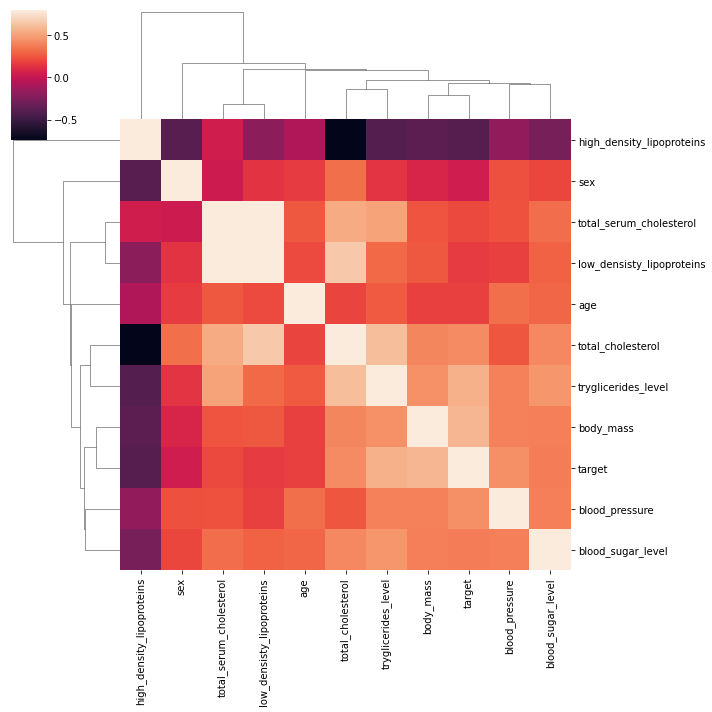

In [ ]:
# visualization of the dataset
import pandas as pd
import seaborn as sns
df = pd.DataFrame(X, columns = ["age", "sex", "body_mass", "blood_pressure", "total_serum_cholesterol", "low_densisty_lipoproteins", "high_density_lipoproteins", "total_cholesterol", "tryglicerides_level", "blood_sugar_level"])
df['target'] = y
corr_mat = df.corr() # compute the correlation matrix of the features vectors
sns.clustermap(corr_mat, vmax = 0.8); # plot a clustered heatmap

## 2.1 Normalization
[Normalize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html) the input data using the L2 norm, as well as the target data by the maximum value.

In [ ]:
# TODO overwrite X,y with normalized versions of the original data
X = ...
y = ...

In [ ]:
# Split the data
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.2, random_state = 14)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.3, random_state = 14)

## 2.2 Implementing gradients for Linear Regression

The model we consider is $\hat{y} = w x + c$.

We need to calculate the gradients for the training dataset $X$ of the loss
$L(w,c) = \frac{1}{2n}\sum_{x_i \in X}(y_i-\hat{y_i})^2 $

What are the gradients?

- $\frac{\partial L(w,c)}{\partial w} = ...$
- $\frac{\partial L(w,c)}{\partial c} = ...$

Implement them below.

In [ ]:
def grad_w(X,y,w,c):
  # outputs parital L(w,c)/ partial w
  y_pred = (w @ X.T + c)
  # TODO
  return ...

In [ ]:
def grad_c(X,y,w,c):
  # outputs parital L(w,c)/ partial c
  y_pred = (w @ X.T + c)
  # TODO
  return ...

Compute the train and test error.
Update the parameters w,c for each gradient step according to the learning rate.

In [ ]:
# Set up stochasic batch gradient descent
BATCHSIZE = 16
EPOCHS = 400
lr = 0.15 # set the learning rate

# set initial values for the parameters
w = np.random.RandomState(seed=43).randn(X_train.shape[1])
c = 0


MSE_test = []
MSE_train = []

# for several epochs (= runs over complete training data)
for e in range(EPOCHS):

  # TODO
  # compute current errors on test and train
  MSE_train.append(...)
  MSE_test.append(...)

  # split the training set into batches
  for b in range(0,((X_train.shape[0]//BATCHSIZE)-1)*BATCHSIZE,BATCHSIZE):

    X_batch = X_train[b:b+BATCHSIZE]
    y_batch = y_train[b:b+BATCHSIZE]

    # TODO
    # run a gradient step on every batch
    w_ = ...
    c_ = ...

    w = w_
    c = c_

# plot the resulting learning curve
plt.plot(np.nan_to_num(MSE_train,nan=1000.0),label='train')
plt.plot(np.nan_to_num(MSE_test,nan=1000.0),label='test')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend()
plt.yscale('log')
print(f'SGD = MSE test {MSE_test[-1]}')

In [ ]:
# Show the predictions
plt.plot((w @ X_test.T + c), y_test, '.')
plt.xlabel('labels predicted by the model')
plt.ylabel('true test labels')

1. Explain in your own words what information the learning curve gives to you.

## 2.3 Loss Curve Quiz

What is wrong?
![L1](https://developers.google.com/static/machine-learning/testing-debugging/images/metric-curve-ex03.svg)   ![L2](https://developers.google.com/static/machine-learning/testing-debugging/images/metric-curve-ex02.svg)     ![L3](https://developers.google.com/static/machine-learning/testing-debugging/images/metric-curve-ex01.svg
)




## 2.4 Comparison with Library solution

Why should we (not) use sklearn instead?

In [ ]:
# plot the learning curve fot the sklearn Ridge estimator
MSE_train = []
MSE_test = []
for i in range(10,X_train.shape[0]):
  lm = linear_model.Ridge(alpha=0.01, fit_intercept = True).fit(X_train[:i], y_train[:i])

  # TODO
  MSE_test.append(...)
  MSE_train.append(...)

plt.plot(MSE_train,label='train')
plt.plot(MSE_test,label='test')
plt.xlabel('datapoints')
plt.ylabel('MSE')
plt.legend()

print(f'sklearn = MSE test {MSE_test[-1]}')

In [ ]:
plt.plot(lm.predict(X_test), y_test, '.')
plt.xlabel('labels predicted by the model')
plt.ylabel('true test labels')

1. What is the difference between the two methods?
2. Should you rather use the Library or your own implementation?

## 2.5 Validation data set
1. We did not use the validation data set so far, do we need it at all?
2. Are there hyperparamters for SGD?
3. How would can you estimate true the generalization error?